In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
np.random.seed(2)

# Bayesian Attribution

## Problem Statement:

We want to incentivize members to do a certain action (e.g, complete a telehealth session).
We offer a range of incentives and would like to assess the effectiveness of each program.
Some members will convert without any incentive (spontaneous of baseline conversion).
Many members will be offered more than one incentive.

## Four Types of Incentives or Promoting Factors:

#### 1. Direct Incentives - Things we do intentionally

* The member is offered cash to convert. 
* We send them a reminder email. 
* We put the link at the top of their homepage.

#### 2. Contributing Factors - Things we know about but have not control over.

* The member is a parent of young children. 
* The member had surgery within the last year. 
* The member has met their deductible for the year.

#### 3. Interaction Factors - Combinations of incentives and factors that work well together.

* The member is a mother AND received a Mother's Day promotion
* The member uses an Android phone AND received promotional message X.

#### 4. Baseline Factors - Everything Else

* The member already knew about our services and decided to use it on their own
* All other factors that we don't know about.
* All factors that we do know about but elected not to include in our model

## Challenges:

Ideally, we would have one group that received Incentive A and nothing else, and another that received Incentive B and nothing else, etc.
Realistically, most members will receive multple direct incentives and have multiple contributing factors outside of our control

There are no members who aren't subject to spontaneous conversion, so we have no direct way to do a WITH/WITHOUT comparison.

Conversion rates tend to be pretty small (~1%), so few, if any, members are likely to convert ($p>0.5$). Small deviations from ideal outcomes result in large error bars.

## Procedure

Each incentive or factor has a fixed probability of resulting in coversion, $P_i$.
Each member has a vector with a $0$ for each incentive/factor they do not have and a $1$ for those they do have.

For convenience, we also include a 'NULL' value of $1$ for every member to account for the baseline that is true for everyone.

We mark the outcome as $0$ if they did not complete the desired outcome and $1$ if they did.

For example:
* member $A$ has factors A,B and E and had a positive outcome
* member $B$ has factors B, C and D and did not convert

In [2]:
df = pd.DataFrame(dtype=int, columns = ['null','A','B','C','D','E','outcome'])
df.loc['Member_1'] = (1,1,1,0,0,1,1)
df.loc['Member_2'] = (1,0,1,1,1,0,0)
df=df.astype(int)
df

,null,A,B,C,D,E,outcome
Member_1,1,1,1,0,0,1,1
Member_2,1,0,1,1,1,0,0


## Additive Probability

Unfortunately, probabilites do not add simply. If a member is offered $4$ incentives that are each known to be $30%$ effective, they don't have a $120%$ probability of conversion.

The probability that a member will convert when presented with several incentives is one minus the probability that they will not convert due to any of the incentives.

$$P_{total} = 1 -(1-P_{null})\cdot (1-P_A)\cdot (1-P_B)\cdot (1-P_C)\cdot (1-P_D)...$$

$$P_i = \text {Success rate of factor i in isolation}$$

$$(1-P_i) = \text {Probability that factor i does not result in conversion}$$

Therefore, the conversion rate if offered $4$ incentives at $30%$ each is:

$$P_{total} = 1 - (1-.3)\cdot (1-.3)\cdot (1-.3)\cdot (1-.3)$$

$$P_{total} = 1 - (.7)\cdot (.7)\cdot (.7)\cdot (.7) = 76\%$$


To account for factors that the member does/does not have, we raise each factor to $0$ or $1$ indicating presence or absence of a factor.


$$P_{total} = 1 - (1-P_A)^{X_A}\cdot (1-P_B)^{X_B}\cdot (1-P_C)^{X_C)}\cdot (1-P_D)^{X_D}\cdot(1-P_E)^{X_E}...$$

So for member $A$:

$$\large P = 1 -(1-P_{null})^1\cdot (1-P_A)^1\cdot (1-P_B)^1\cdot (1-P_C)^0\cdot (1-P_D)^0\cdot (1-P_E)^1$$

$$\large P = 1 -(1-P_{null})\cdot (1-P_A)\cdot (1-P_B)\cdot (1-P_E)$$





A convenient way to handle the product of multiple terms is $e$ raised to the sum of the logarithms of the terms:

$$\large \prod_{i}(x) = e^{\sum_{i}ln(x)}$$

So $P_{total}$ becomes:

$$\large P_{total} = 1 - \prod_{i=A,B,C,D,E...}(1-P_i)^{X_i}$$


$$\large P_{total} = 1 - e^{\sum_{i}X_i\cdot ln(1-P_i)}$$

$$\large P_{total} = 1-e^{\vec X \cdot {ln(1-\vec P)}}$$

### This gives us the ability to distinguish between conversion *because of* a factor vs. conversion *with a factor*

$$\large \underbrace {P_\text{(A and other factors)}}_\text {conversion with A and other factors} = 1 - \underbrace {(1-P_A)}_\text {conversion due to A alone}\cdot \underbrace {\prod_{i\ne A}(1-P_i)^{X_i}}_\text {conversion due to all factors execpt A}$$

$$ $$

$$\large \underbrace {P_{A}}_\text{conversion due to A alone} = 1-\frac{1-P_\text{(with A)}}{1-P_\text{(without A)}}$$

#### Note: For a first approximation, we assume that $X_i$ is independent of $A$. That is to say, the presence of factors *B,C,D,E, etc* are distribute the same for people with factor *A* and those without it.  (We will correct for this later)

$\large P_\text{(with A)}$ and $\large P_\text{(without A)}$ can be read directly from our results table, e.g:
```
SQL:

SELECT A, AVERAGE(OUTCOME) FROM results GROUP BY A
```

## The Bayesian Part

$$\large P_{A} = 1-\frac{1-P_\text{(A=1)}}{1-P_\text{(A=0)}}$$

However, as we learned last time, $P$ is not just a single value. Estimates of $P$ are distributed over a range of values in the vicinity of true $P$.

The width of this vicinity depends on how much data we have.


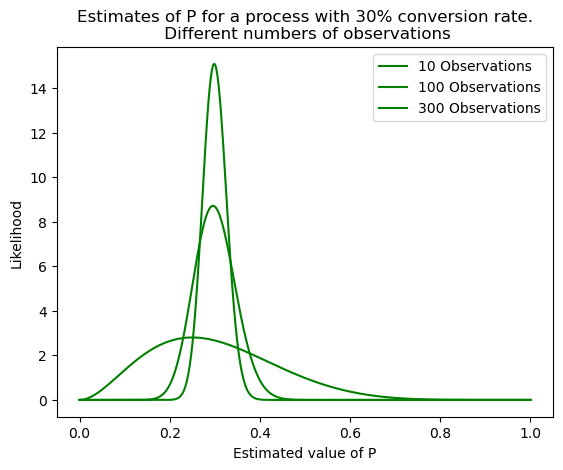

In [3]:
x = np.linspace(0,1,1000)
[plt.plot(x, beta(3*i,7*i).pdf(x), color='green', label=f'{i*10} Observations' ) for i in (1,10,30)]
plt.title('Estimates of P for a process with 30% conversion rate.\n Different numbers of observations')
plt.legend()
plt.xlabel('Estimated value of P')
plt.ylabel('Likelihood');

# Let's look at some experimental data.

### 6,400 Members received between 2 and 5 Incentives (plus the null value)

### In total, 2,502 members converted (46%)

### Because all members received at least two incentives, we can't get a clean read on any of them.

In [791]:
df = pd.read_csv('results_data1.csv')#.sample(frac=.2)
# df=df[df.iloc[:,:-1].sum(axis=1)>2]
# df['Incentive_3']=np.random.choice((0,1), len(df))
# df['Incentive_4']=np.random.choice((0,1), len(df))
# df['Incentive_2']=np.random.choice((0,1), len(df))
df

,null,Incentive_1,Incentive_2,Incentive_3,Incentive_4,Incentive_5,outcome
0,1,0,0,1,1,1,1
1,1,0,0,1,0,1,0
2,1,0,0,0,0,1,0
3,1,0,0,0,1,0,0
4,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...
159995,1,0,0,0,0,1,0
159996,1,0,0,1,1,0,0
159997,1,0,0,0,1,0,0
159998,1,0,0,0,0,1,1


In [792]:
df.describe()

,null,Incentive_1,Incentive_2,Incentive_3,Incentive_4,Incentive_5,outcome
count,160000.0,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000,160000.000000
mean,1.0,0.030194,0.119231,0.268694,0.480006,0.748463,0.349662
std,0.0,0.171121,0.324061,0.443282,0.499602,0.433898,0.476865
min,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.0,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [793]:
true = np.array([0.05, 0.09, 0.13, 0.17, 0.21, 0.25])

In [794]:
df.groupby(['Incentive_1','outcome']).sum()['null']

Incentive_1  outcome
0            0          101184
             1           53985
1            0            2870
             1            1961
Name: null, dtype: int64

In [795]:
with_a/(with_a+with_b), without_a/(without_a+without_b)

(0.40075811221727, 0.20580507944451396)

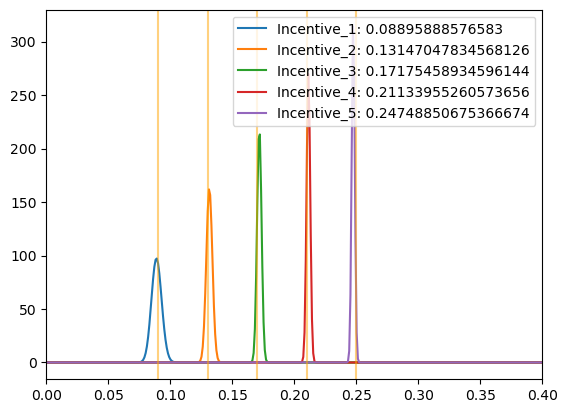

In [796]:
estimated_probabilities = {}
for i in (1,2,3,4,5):
    (without_b,
     without_a,
     with_b,
     with_a) = df.groupby([f'Incentive_{i}','outcome']).sum()['null'].values
    with_=beta(with_a, with_b)
    without_=beta(without_a, without_b)
    P = 1-(1-with_.mean())/(1-without_.mean())
    N = df[f'Incentive_{i}'].sum()
    because_a = P*N
    because_b = (1-P)*N
    because = beta(because_a,because_b)
    estimated_probabilities[i] = because.mean()

    plt.plot(x, because.pdf(x), label = f'Incentive_{i}: {because.mean()}')
plt.xlim([0,.4])
plt.legend()
[plt.axvline(i, color='orange', alpha=.5) for i in true[1:]];

In [797]:
estimated_probabilities, true[1:]

({1: 0.08895888576583,
  2: 0.13147047834568126,
  3: 0.17175458934596144,
  4: 0.21133955260573656,
  5: 0.24748850675366674},
 array([0.09, 0.13, 0.17, 0.21, 0.25]))

In [798]:
first_estimate = 1-np.exp(np.log(1-df.iloc[:,1:-1]*estimated_probabilities.values()).sum(axis=1))
first_estimate

0         0.508456
1         0.376736
2         0.247489
3         0.211340
4         0.406524
            ...   
159995    0.247489
159996    0.346796
159997    0.211340
159998    0.247489
159999    0.171755
Length: 160000, dtype: float64

In [799]:
first_estimate.sum()

50315.00343492727

In [800]:
df['outcome'].sum()

55946

(0.05043360406274019, 0.0522485577423637)

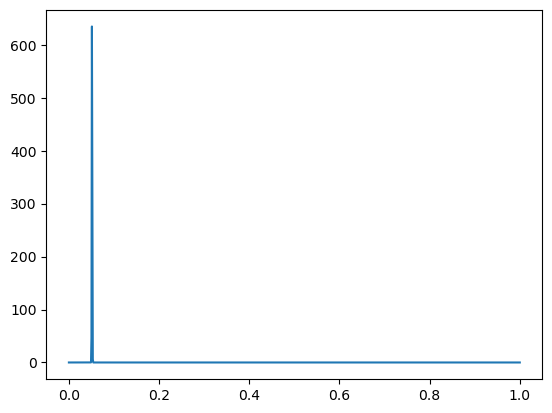

In [801]:
spontaneous = 1 - (1-beta(df['outcome'].sum(), len(df)-df['outcome'].sum()).mean())/(1-beta(first_estimate.sum(),len(df)-first_estimate.sum()).mean())
spontaneous= beta(len(df)*spontaneous, len(df)*(1-spontaneous))
plt.plot(x, spontaneous.pdf(x));
spontaneous.interval(.9)

In [802]:
estimated_probabilities[0] = spontaneous.mean()
estimated = np.array([estimated_probabilities[i] for i in range(len(estimated_probabilities))])
estimated

array([0.05133789, 0.08895889, 0.13147048, 0.17175459, 0.21133955,
       0.24748851])

In [803]:
f=1
(1-np.exp(np.log(1-(df.iloc[:,:-1]*estimated).drop(f'Incentive_{f}',axis=1)).sum(axis=1))).sum()

55666.67652309359

with 1961 2870 0.4059200993583109
0.08895888576583 0.0859629667523304 0.09
with 8130 10947 0.4261676364208209
0.13147047834568126 0.13128556394920443 0.13
with 18714 24277 0.4353004117140797
0.17175458934596144 0.1718253533062608 0.17
with 32963 43838 0.42920014062316897
0.21133955260573656 0.2113445852846737 0.21
with 47824 71930 0.39935200494346745
0.24748850675366674 0.24752977065747872 0.25


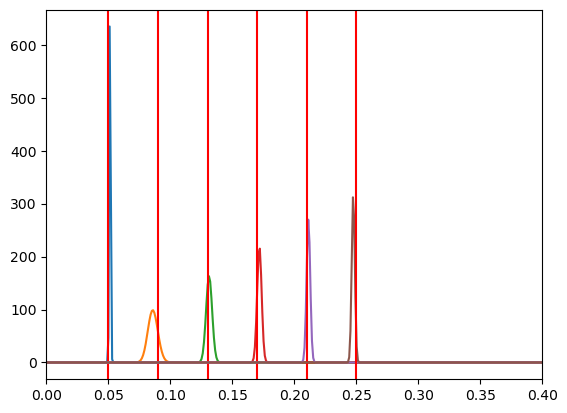

In [804]:
plt.plot(x, spontaneous.pdf(x), label=f'Spontaneous {spontaneous.mean()}')
plt.axvline(true[0], color='red')

for i in (1,2,3,4,5):
    subset = df[df[f'Incentive_{i}']==1]
    
    with_ = beta(subset['outcome'].sum(), (1-subset['outcome']).sum())
    print('with',subset['outcome'].sum(), (1-subset['outcome']).sum(), with_.mean())
    other_factors = (1-subset.iloc[:,:-1]*estimated).drop(f'Incentive_{i}',axis=1)
#     print(other_factors)
    predicted = (1-np.exp(np.log(other_factors).sum(axis=1))).sum()
    
    without_ = beta(predicted, len(subset)-predicted)
#     print('predicted',predicted,len(subset)-predicted, without_.mean())
    p = 1-(1-with_.mean())/(1-without_.mean())
#     print('because',p, true[i], len(subset))
#     print('a ',p*len(subset), ' b ',(1-p)*len(subset))
    new_estimate = beta(p*len(subset),(1-p)*len(subset))
    plt.plot(x, new_estimate.pdf(x))
    print(estimated_probabilities[i],new_estimate.mean(), true[i])
    plt.axvline(true[i], color='red')
#     plt.axvline(estimated_probabilities[i])
plt.xlim([0,.4]);

In [805]:
.6/.65

0.923076923076923

In [806]:
second_estimate = 1-np.exp((np.log(1-df.iloc[:,:-1]*estimated)).sum(axis=1))
second_estimate

0         0.533691
1         0.408733
2         0.286121
3         0.251828
4         0.436992
            ...   
159995    0.286121
159996    0.380330
159997    0.251828
159998    0.286121
159999    0.214275
Length: 160000, dtype: float64

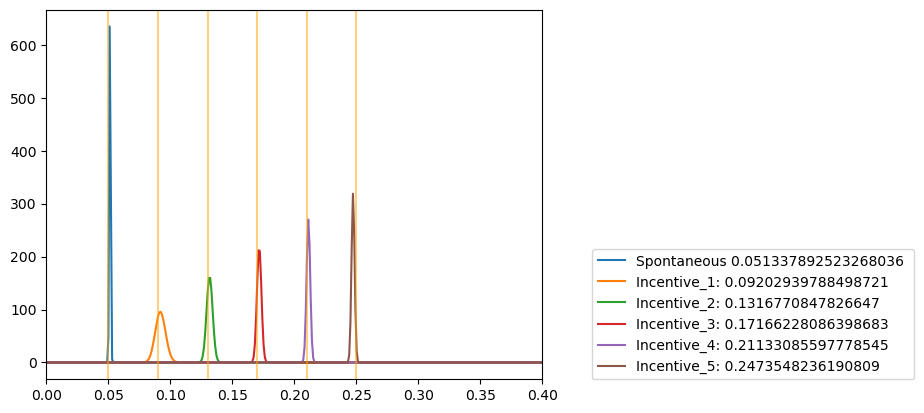

In [807]:
estimated_probabilities = {}
plt.plot(x, spontaneous.pdf(x), label=f'Spontaneous {spontaneous.mean()} ')
for i in (1,2,3,4,5):
    without_b = (1-second_estimate[df[f'Incentive_{i}']==0]).sum()
    without_a = second_estimate[df[f'Incentive_{i}']==0].sum()
    with_b = (1-second_estimate[df[f'Incentive_{i}']==1]).sum()
    with_a = second_estimate[df[f'Incentive_{i}']==1].sum()
    with_=beta(with_a, with_b)
    without_=beta(without_a, without_b)
    P = 1-(1-with_.mean())/(1-without_.mean())
    N = df[f'Incentive_{i}'].sum()
    because_a = P*N
    because_b = (1-P)*N
    because = beta(because_a,because_b)
    estimated_probabilities[i] = because.mean()

    plt.plot(x, because.pdf(x), label = f'Incentive_{i}: {because.mean()}')
plt.xlim([0,.4])
plt.legend(loc=[1.1,0])
[plt.axvline(i, color='orange', alpha=.5) for i in true];

In [130]:
def get_a(dist):
    return ((dist.mean()*(1-dist.mean())/(dist.var())-1)*dist.mean())
def get_b(dist):
    return ((dist.mean()*(1-dist.mean()))/(dist.var())-1)*(1-dist.mean())

In [8]:
get_a(without_), get_b(without_), get_a(with_), get_b(with_)

(8.0, 22.0, 10.0, 20.000000000000004)

In [9]:
1-(1-with_.mean())/(1-without_.mean())

0.09090909090909083

In [38]:
with_.mean(), without_.mean()

(0.3333333333333333, 0.26666666666666666)

In [46]:
1-(1-with_.ppf([.19/2,.5,1-.19/2]))/(1-without_.ppf([.19/2, .5, 1-.19/2]))

array([0.0699218, 0.0922844, 0.1165074])

In [48]:
A = 1-(1-with_.mean())/(1-without_.mean())
A

0.09090909090909083

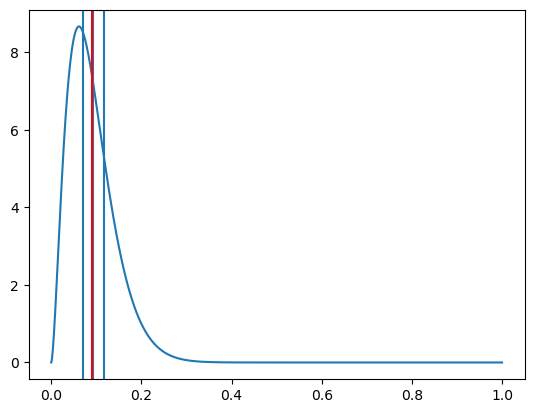

In [55]:
plt.plot(x,beta(A*30, (1-A)*30).pdf(x))
[plt.axvline(i) for i in 1-(1-with_.ppf([.19/2,.5,1-.19/2]))/(1-without_.ppf([.19/2, .5, 1-.19/2]))]
plt.axvline(A, color='red')

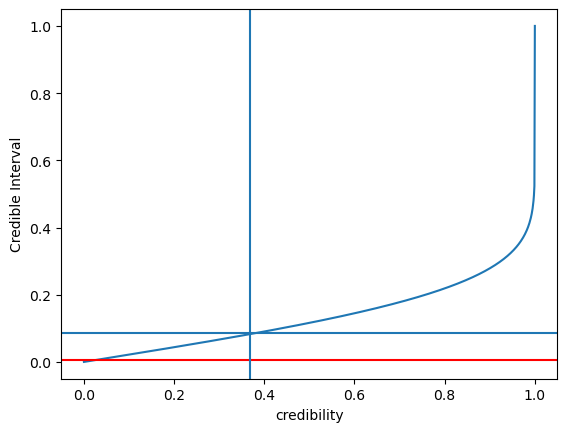

In [37]:
plt.plot(x,[(with_.interval(i)[1]-with_.interval(i)[0]) for i in x])
plt.ylabel('Credible Interval')
plt.xlabel('credibility')
plt.axhline(with_.var()**.5)
plt.axhline(with_.var(), color='red')
# plt.xlim([.3,.4])
# plt.ylim([0,.2])
plt.axvline(1/np.e)

In [12]:
1/np.exp(1)

0.36787944117144233

In [13]:
.5-1/(2*np.e)

0.31606027941427883

In [14]:
.5+1/(2*np.e)

0.6839397205857212

In [15]:
(with_.ppf(.5+1/(2*np.e))- with_.ppf(.5-1/(2*np.e)))**2

0.006833787974928042

In [16]:
with_.var()

0.007168458781362007

In [17]:
lo = .5-1/(2*np.e)
hi = .5+1/(2*np.e)
lo, hi

(0.31606027941427883, 0.6839397205857212)

In [18]:
with_.ppf(hi),with_.ppf(lo)

(0.3718022556647873, 0.28913552732183156)

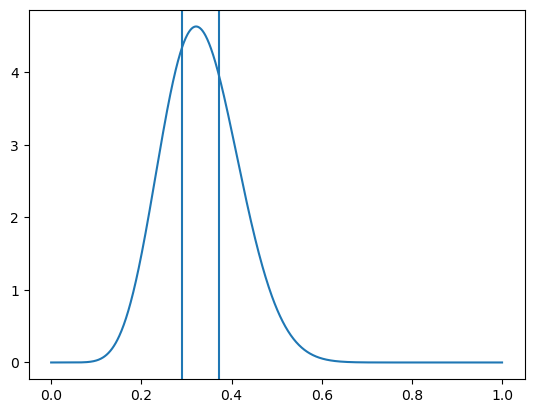

In [19]:
plt.plot(x,with_.pdf(x))
[plt.axvline(with_.ppf(i)) for i in (hi,lo)]

In [20]:
with_.interval(1/np.e)

(0.28913552732183156, 0.3718022556647873)

In [21]:
1-(1-with_.mean())/(1-without_.mean())

0.09090909090909083

In [22]:
8/22

0.36363636363636365

In [23]:
10/20

0.5

In [31]:
1-(1-8/22)*(.9)

0.42727272727272725

In [32]:
without_.mean()

0.26666666666666666